In [80]:
%%capture
!pip install -qqq transformers datasets evaluate torchvision accelerate tensorflow

In [1]:
from datasets import load_dataset
from transformers import AutoImageProcessor


# Inputs from the user
DATASET_NAME = "food101"
MODEL_NAME = "google/vit-base-patch16-224-in21k"
IMAGE_COL = "image"
LABEL_COL = "label"
LOG_MODEL_MLFLOW = True
LOG_DATA_MLFLOW = True

ds = load_dataset(DATASET_NAME)
image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

Found cached dataset parquet (/Users/benepstein/.cache/huggingface/datasets/ybelkada___parquet/ybelkada--food101-tiny-0972535cdb41ae72/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# @MARIO - Optional code only if they have a pandas dataframe...

import pandas as pd
from datasets import ClassLabel, Dataset, DatasetDict

# If their data is in a pandas dataframe
# df = pd.DataFrame(...)
# Create a huggingface dataset here
def pandas_to_hf(df: pd.DataFrame) -> DatasetDict:
    """Convert a pandas df"""
    ds = Dataset.from_pandas(df)
    labels = sorted(df[LABEL_COL].unique())
    class_label = ClassLabel(num_classes=len(labels), names=labels)
    ds = ds.cast_column(LABEL_COL, class_label)
    return ds
    
# ds = pandas_to_hf(df)


In [3]:
from PIL.Image import Image as PIL_Image
from datasets import Dataset

# If the dataset dict only has 1 key, we want to split it into train/test
if len(ds.keys()) == 1:
    key = next(iter(ds.keys()))
    ds = ds[key]

# If we have a dataset, we want to create a dict with train/test
if isinstance(ds, Dataset):
    ds = ds.train_test_split(test_size=0.2, stratify_by_column=LABEL_COL)
    

splits = list(ds.keys())
train_split = "train" if "train" in splits else "training"
eval_split = next(split for split in splits if split != train_split)


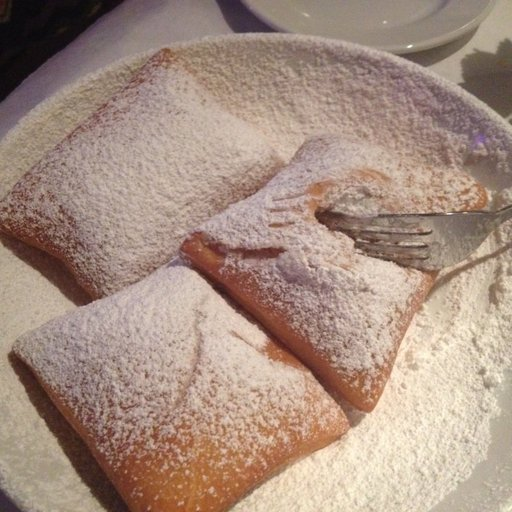

In [5]:
# Some validation - Must be a PIL image
assert isinstance(ds[train_split][0][IMAGE_COL], PIL_Image), "Data must have PIL images loaded to train"

# View first sample
ds[train_split][0][IMAGE_COL]

In [7]:
# Standard image preprocessing. Feel free to add more!
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from typing import Dict, List

# Crop a random part of the image, resize it, and normalize it with the image mean and standard deviation
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
transformations = Compose([RandomResizedCrop(size), ToTensor(), normalize])


def transforms(examples: Dict[str, List]):
    """Apply the transformations and return the pixel_values"""
    examples["pixel_values"] = [transformations(img.convert("RGB")) for img in examples[IMAGE_COL]]
    del examples[IMAGE_COL]
    return examples


ds = ds.with_transform(transforms)

In [9]:
from transformers import DefaultDataCollator
import evaluate
from evaluate import EvaluationModule
import numpy as np


EVAL_METRIC = "accuracy"
metric = evaluate.load(EVAL_METRIC)

def compute_metrics(eval_pred: EvaluationModule):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


In [10]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import mlflow.transformers
import os


mlflow.transformers.autolog(
    log_input_examples=True, 
    log_model_signatures=True, 
    log_models=True, 
    log_datasets=True
)

# Mappings to/from labels and ids
labels = ds[train_split].features[LABEL_COL].names
id2label = dict(enumerate(labels))
label2id = {v: k for k, v in id2label.items()}

data_collator = DefaultDataCollator()

model = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

mlflow_run_name = "run1"

training_args = TrainingArguments(
    output_dir=mlflow_run_name,          
    remove_unused_columns=False,
    evaluation_strategy="epoch",      # User Input ["epoch", "batch"]
    save_strategy="epoch",            # User Input ["epoch", "batch"]
    learning_rate=5e-5,               # User Input, use this default
    per_device_train_batch_size=16,   # User Input, use this default
    gradient_accumulation_steps=4,    # User Input, use this default
    per_device_eval_batch_size=16,    # User Input, use this default
    num_train_epochs=3,               # User Input, use this default
    warmup_ratio=0.1,                 # User Input, use this default
    logging_steps=10,                 # User Input, use this default
    load_best_model_at_end=True,
    metric_for_best_model=EVAL_METRIC,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds[train_split],
    eval_dataset=ds[eval_split],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/benepstein/Documents/GitH

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,4.592235,0.000000
1,No log,4.407637,0.300000


TrainOutput(global_step=2, training_loss=4.5601043701171875, metrics={'train_runtime': 52.5244, 'train_samples_per_second': 3.046, 'train_steps_per_second': 0.038, 'total_flos': 9927775833292800.0, 'train_loss': 4.5601043701171875, 'epoch': 1.6})

In [11]:
# Log the dataset and model to mlflow
run_id = mlflow.last_active_run().info.run_id
with mlflow.start_run(run_id=run_id):
    if LOG_MODEL_MLFLOW:
        model_config = {
            "model": trainer.model,
            "image_processor": trainer.tokenizer
        }
        mlflow.transformers.log_model(model_config, artifact_path="model")
    if LOG_DATA_MLFLOW:
        for split in ds.keys():
            data = mlflow.data.from_huggingface(ds[split])
            mlflow.log_input(data, context=split)
    

2023/06/28 15:50:42 WARNING mlflow.transformers: This model is unable to be used for pyfunc prediction because the model is not a language-based model and requires a complex input type that is currently not supported. The pyfunc flavor will not be added to the Model.
2023/06/28 15:50:47 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/2q/xy9rl8zn00b9_3ync0yk3jm40000gn/T/tmpi46brplt/model, flavor: transformers), fall back to return ['transformers==4.28.1', 'torch==2.0.1', 'torchvision==0.15.2', 'accelerate==0.20.3']. Set logging level to DEBUG to see the full traceback.
2023/06/28 15:50:48 WARNING mlflow.data.huggingface_dataset: Failed to infer schema for Hugging Face dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/06/28 15:50:48 WARNING mlflow.data.huggingface_dataset